In [2]:
import numpy as np
import multiprocessing #多线程处理
import cv2
import matplotlib.pyplot as plt #绘图


import rosbag #处理rosbag
from cv_bridge import CvBridge

import sys
sys.path.append('/home/gwp/rpg_vid2e/rosbag_reading')  # 替换为实际的路径(注意如果修改了py文件的代码需要重新restart kernel)
from utils.bag_utils import read_H_W_from_bag, read_tss_us_from_rosbag, read_images_from_rosbag, read_evs_from_rosbag, read_evs_from_rosbag_intimestamp
print("import ultils to process the rosbag")

import ultils to process the rosbag


In [3]:
rosbag_file="../example/HKU-dataset/HKU_aggressive_small_flip.bag"
# 从rosbag文件中读取数据
bag_data = rosbag.Bag(rosbag_file, "r")

topics = list(bag_data.get_type_and_topic_info()[1].keys())
print("all the topic name in this rosbag",topics)

all the topic name in this rosbag ['/cpy_uav/viconros/odometry', '/davis_left/events', '/davis_left/image_raw', '/davis_left/imu', '/davis_right/events', '/davis_right/image_raw', '/davis_right/imu']


In [4]:
image_topic_name='/davis_left/image_raw';

# 读取图像的长与宽
H, W = read_H_W_from_bag(bag_data, image_topic_name)
# 读取全部图像数据
imgs = read_images_from_rosbag(bag_data, image_topic_name, H=H, W=W)


Read H, W from bag: 260, 346


  0%|          | 0/1726 [00:00<?, ?it/s]

 27%|██▋       | 463/1726 [00:10<00:25, 48.82it/s]

 62%|██████▏   | 1066/1726 [00:25<00:15, 42.09it/s]

100%|██████████| 1726/1726 [00:41<00:00, 41.89it/s]


extract num of image 10


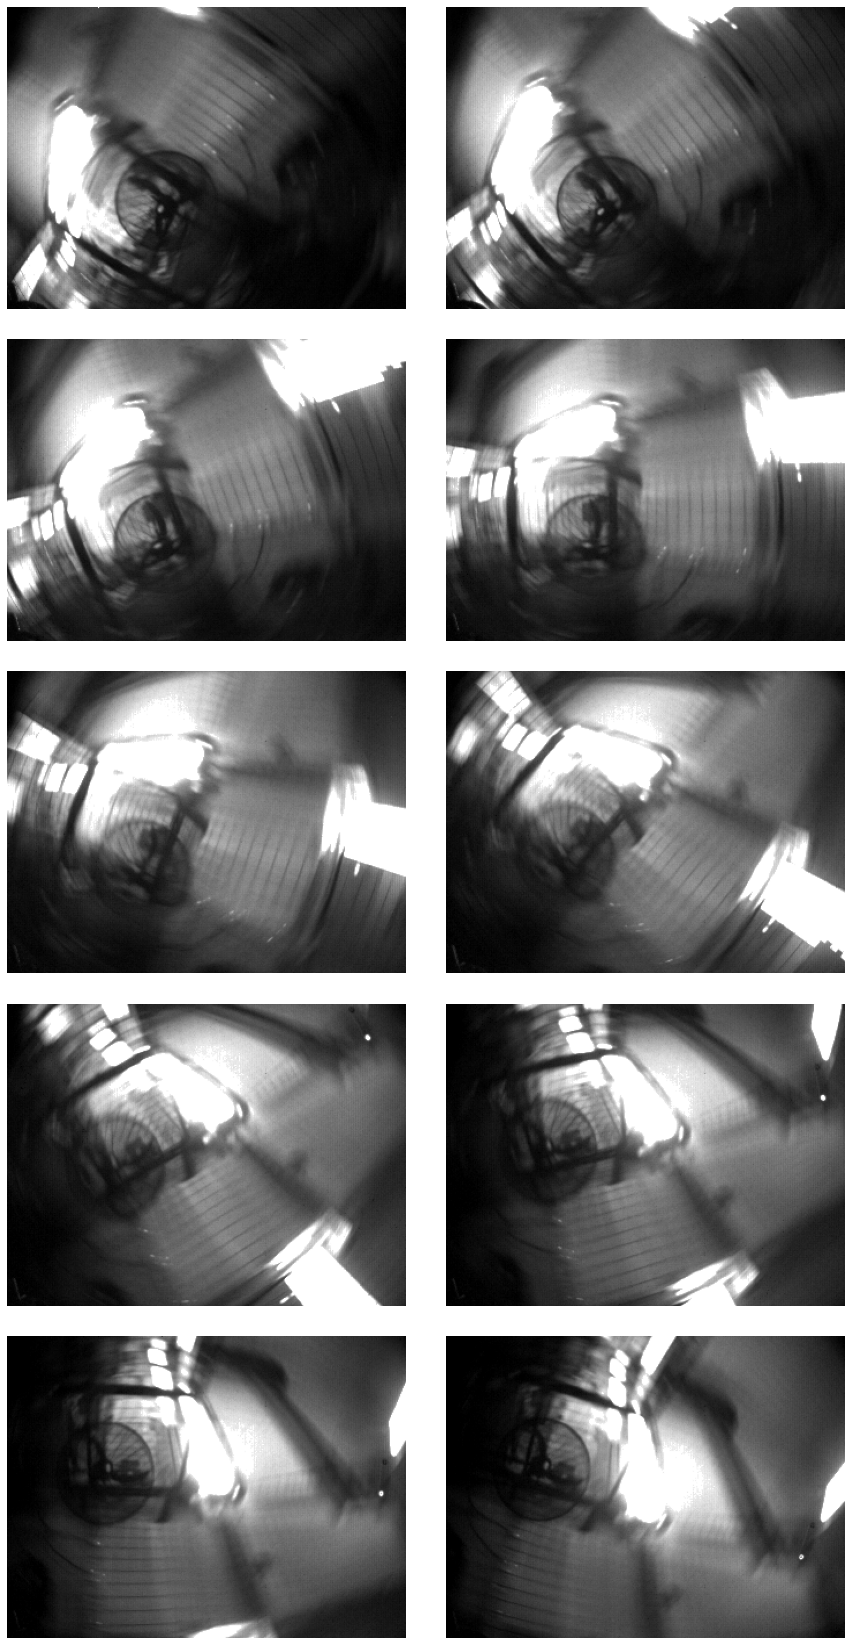

timestamp of the first image 1666334010130768.8 
timestamp of the last image 1666334010518417.8
the hz of the image topic is:  25


In [32]:
# 获取一组图片
image_index=900;
image_set=imgs[image_index:image_index+10]#提取10张图片
print("extract num of image",len(image_set))

# 将十张图片都显示出来

# 定义子图的行和列
rows = 5
cols = 2

# 创建一个图形对象，并定义子图的尺寸
fig, axes = plt.subplots(rows, cols, figsize=(15, 30))

# 同时将图片也保存出来
import os
images_dir = os.path.join(os.path.dirname(rosbag_file), 'imgs')
import shutil
if os.path.exists(images_dir): # 如果目标目录存在，则删除它
    shutil.rmtree(images_dir)
else:
    os.makedirs(images_dir) # 如果不存在就创建目标目录

# 遍历每一张图片，并显示在相应的子图中
for i, image in enumerate(image_set):
    ax = axes[i // cols, i % cols]
    # image_color = np.stack([image, image, image], -1)  # 将灰度图像转换为RGB图像

    # 保存图片
    img_filename = f"img_{i:08d}.png"
    img_path = os.path.join(images_dir, img_filename)
    cv2.imwrite(img_path, image)  # 使用cv2.imwrite保存图片

    image_color = image[:, :, None].repeat(3, axis=2) # 把real event画在image上, (H,W) -> (H,W,1) -> (H,W,3)
    ax.imshow(image_color, aspect='auto') # 保持原图像比例
    ax.axis('off')  # 不显示坐标轴

# 调整子图之间的间距
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# 读取图像的时间戳
timestamp_imgs_us = read_tss_us_from_rosbag(bag_data, image_topic_name)
#提取上面选择的10张图片对应的时间戳
timestamp_imgs_us_set=timestamp_imgs_us[image_index:image_index+10]
assert len(timestamp_imgs_us_set) == len(image_set)

timestamp_us_0=timestamp_imgs_us_set[0];#第一张图片的时间戳
timestamp_us_1=timestamp_imgs_us_set[-1];#最后一张图片的时间戳
print("timestamp of the first image",timestamp_us_0,"\ntimestamp of the last image",timestamp_us_1)
frequency_hz_image=int(1e6/(timestamp_us_1-timestamp_us_0)*len(timestamp_imgs_us_set))#计算帧率
print("the hz of the image topic is: ",frequency_hz_image)

fps_file_path = os.path.join(os.path.dirname(rosbag_file), 'fps.txt')
# 如果fps.txt文件存在，则删除它
if os.path.exists(fps_file_path):
    os.remove(fps_file_path)

# 将频率写入fps.txt文件
with open(fps_file_path, 'w') as f:
    f.write(f"{frequency_hz_image}")